In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm  # 导入 tqdm 进度条


# 定义MLP模型
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 数据集加载器
def get_data_loaders(dataset_name, batch_size, data_dir="./data"):
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    if dataset_name == "MNIST":
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )
        train_dataset = datasets.MNIST(
            data_dir, train=True, download=True, transform=transform
        )
        test_dataset = datasets.MNIST(
            data_dir, train=False, download=True, transform=transform
        )
    elif dataset_name == "CIFAR10":
        transform_train = transforms.Compose(
            [
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
                ),
            ]
        )
        transform_test = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
                ),
            ]
        )
        train_dataset = datasets.CIFAR10(
            data_dir, train=True, download=True, transform=transform_train
        )
        test_dataset = datasets.CIFAR10(
            data_dir, train=False, download=True, transform=transform_test
        )
    else:
        raise ValueError("Unsupported dataset")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# 训练函数
def train(
    model,
    device,
    train_loader,
    test_loader,
    optimizer,
    scheduler,
    criterion,
    total_data_limit,
    log_interval=1000,
):
    model.train()
    total_data = 0
    accuracies = []
    data_amounts = []

    with tqdm(total=total_data_limit, desc="Training", unit="sample") as pbar:
        accuracy = 0
        while total_data < total_data_limit:
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                total_data += len(data)

                pbar.update(len(data))
                pbar.set_postfix(
                    {"Total Data": total_data, "Accuracy": f"{accuracy:.2f}%"}
                )

                if batch_idx % log_interval == 0 or total_data >= total_data_limit:
                    accuracy = test(model, device, test_loader, criterion)
                    accuracies.append(accuracy)
                    data_amounts.append(total_data)

                if total_data >= total_data_limit:
                    break
            if total_data < total_data_limit:
                scheduler.step()

    return data_amounts, accuracies


# 测试函数
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100.0 * correct / len(test_loader.dataset)
    return accuracy


# 通用评估函数
def eval(
    model_name,
    dataset_name,
    batch_size=32,
    total_data_limit=20000,
    log_interval=10,
    data_dir="./data",
    lr=0.01,
    momentum=0.9,
):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    train_loader, test_loader = get_data_loaders(dataset_name, batch_size, data_dir)

    if model_name == "MLP" and dataset_name == "MNIST":
        model = MLP().to(device)
        total_epoch = int(total_data_limit / 60000)
    elif model_name == "ResNet18" and dataset_name == "CIFAR10":
        model = models.resnet18(num_classes=10).to(device)
        total_epoch = int(total_data_limit / 50000)
    else:
        raise ValueError("Unsupported model or dataset combination")

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_epoch)
    criterion = nn.CrossEntropyLoss()

    return train(
        model,
        device,
        train_loader,
        test_loader,
        optimizer,
        scheduler,
        criterion,
        total_data_limit,
        log_interval,
    )

# all_data_amounts, all_accuracies = eval('MLP', 'MNIST', batch_size=32, total_data_limit=20000)

In [3]:
from scipy.optimize import curve_fit


def data_fit(all_data_amounts, all_accuracies):

    # 定义拟合函数
    def func(x, k1, k2, k3):
        return k1 * np.log(k2 * x + k3)

    # 拟合数据
    popt, pcov = curve_fit(
        func, all_data_amounts, np.array(all_accuracies) / 100
    )  # 归一化准确率

    # 生成拟合曲线
    x_fit = np.linspace(all_data_amounts[0], max(all_data_amounts), 100)
    y_fit = func(x_fit, *popt)

    # 绘制图形
    plt.figure(figsize=(8, 6))
    plt.plot(
        all_data_amounts, np.array(all_accuracies) / 100, "bo", label="data fitted"
    )  # 绘制原始数据点

    plt.plot(x_fit, y_fit, "r-", label="fitted curve")  # 绘制拟合曲线
    plt.xlabel("Number of Samples")
    plt.ylabel("Test Accuracy (%)")
    plt.title("Accuracy vs. Data Amount (MNIST)")
    plt.legend()
    plt.grid(True)

    # 添加拟合方程文本注释
    equation_text = f"{popt[0]:.5f} * log({popt[1]:.5f} * x + {popt[2]:.5f})"
    plt.annotate(
        equation_text,
        xy=(x_fit[50], y_fit[50]),
        xytext=(x_fit[30], y_fit[50] - 0.1),
        arrowprops=dict(facecolor="black", shrink=0.05, width=1, headwidth=6),
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.5),
    )

    plt.show()

In [4]:
def train_models():
    # MLP+MNIST
    #all_data_amounts, all_accuracies = eval('MLP', 'MNIST', batch_size=32, total_data_limit=20000)
    #torch.save({'data_amounts': all_data_amounts, 'accuracies': all_accuracies}, './results/eval_results_eval1.pt')


    # ResNet18+CIFAR10
    all_data_amounts, all_accuracies= eval('ResNet18', 'CIFAR10', batch_size=32, total_data_limit=2000000, log_interval=1000)
    torch.save({'data_amounts': all_data_amounts, 'accuracies': all_accuracies}, './results/eval_results_eval2.pt')

# train_models()

[50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000, 1050000, 1100000, 1150000, 1200000, 1250000, 1300000, 1350000, 1400000, 1450000, 1500000, 1550000, 1600000, 1650000, 1700000, 1750000, 1800000, 1850000, 1900000, 1950000, 2000000]
[10.0, 18.93, 42.51, 47.73, 54.84, 58.52, 61.87, 63.53, 66.14, 67.22, 68.84, 70.57, 71.75, 72.66, 72.84, 73.48, 74.68, 75.3, 73.02, 76.45, 76.4, 76.98, 77.14, 77.33, 77.75, 78.34, 78.59, 78.6, 78.91, 79.5, 79.42, 79.99, 79.96, 80.1, 80.58, 80.34, 80.79, 80.89, 81.17, 81.29]


C:\Users\56844\AppData\Local\Temp\ipykernel_8732\2505993626.py:8: RuntimeWarning: invalid value encountered in log
  return k1 * np.log(k2 * x + k3)


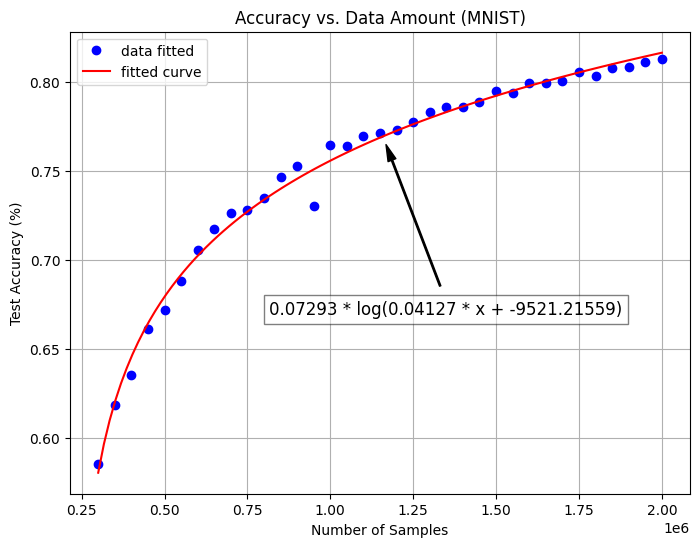

In [5]:
def draw(data_path):
    # 读取数据从文件
    loaded_data = torch.load(data_path)
    all_data_amounts = loaded_data['data_amounts']
    all_accuracies = loaded_data['accuracies']

    # 验证读取的数据是否正确
    print(all_data_amounts)
    print(all_accuracies)
    data_fit(np.array(all_data_amounts[5:]), all_accuracies[5:])

draw('./eval_results.pt')
# draw('./results/eval_results_eval1.pt')
# draw('./results/eval_results_eval2.pt')